# Planning Notebook

In [5]:
import math
import unittest
import numpy as np
from itertools import product
import tqdm
from tqdm import tqdm_notebook
import copy
import pickle
import time

# import gtsam
import gtsam
from gtsam import *
from gtsam.utils.test_case import GtsamTestCase

# import gtbook
import gtbook
from gtbook.display import *
from gtbook.discrete import *

# import local package
import gtsam_planner
from gtsam_planner import *

# import parser
import SASParser
from SASParser import SAS, Operator
from typing import List, Tuple, Callable, Dict, Iterable

DiscreteKey = Tuple[int, int]

variables = Variables()
def pretty(obj): 
    return gtbook.display.pretty(obj, variables)

import graphviz
class show(graphviz.Source):
    """ Display an object with a dot method as a graph."""

    def __init__(self, obj):
        """Construct from object with 'dot' method."""
        # This small class takes an object, calls its dot function, and uses the
        # resulting string to initialize a graphviz.Source instance. This in turn
        # has a _repr_mimebundle_ method, which then renders it in the notebook.
        super().__init__(obj.dot())

In [6]:
class SASToGTSAM():
    def __init__(self, sas):
        self.sas = sas
        self.init = sas.initial_state
        self.goal = sas.goal
        self.vars = self.sas.variables
        self.ops = self.sas.operators
        self.mutex_groups = self.sas.mutex_group
        self.ops_names = []
        for op in self.ops:
            self.ops_names.append(op.name)
        self.state_keys = list(self.vars.keys())
    
    def generate_state(self, timestep):
        state = []
        for var, val in self.vars.items():
            state_var = variables.discrete(str(var)+"_"+str(timestep), val)
            state.append(state_var)
        return state
    
    def generate_operator_key(self, timestep):
        op_var = variables.discrete("op_"+str(timestep), self.ops_names)
        return op_var
    
    def generate_opkey_improved(self, timestep, cardinality):
        op_var = variables.discrete("op_"+str(timestep), range(cardinality))
        return op_var
    
    def generate_initial_factor(self, initial_state):
        keys = gtsam.DiscreteKeys()
        for key in initial_state:
            keys.push_back(key)
        init_values = list(self.init.values())
        init_f = gtsam_planner.MultiValueConstraint(keys, init_values)
        return init_f

    def generate_goal_factor(self, goal_state):
        keys = gtsam.DiscreteKeys()
        vals = []
        for goal_var, goal_val in self.goal.items():
            keys.push_back(goal_state[self.state_keys.index(goal_var)])
            vals.append(goal_val)
        goal_f = gtsam_planner.MultiValueConstraint(keys, vals)
        return goal_f
    
    def generate_op_null(self, state_t, state_tp, operator):
        pre_vals = []
        eff_vals = []
        op_keys = set()
        pre_set = set()
        eff_set = set()
        pre_keys = gtsam.DiscreteKeys()
        eff_keys = gtsam.DiscreteKeys()
        for pre_var, pre_val in operator.precondition.items():
            key = state_t[self.state_keys.index(pre_var)]
            op_keys.add(key)
            pre_set.add(key)
            if pre_val == -1:
                continue
            pre_keys.push_back(key)
            pre_vals.append(pre_val)
        
        for eff_var, eff_val in operator.effect.items():
            key = state_tp[self.state_keys.index(eff_var)]
            op_keys.add(key)
            eff_set.add(key)
            if eff_val == -1:
                continue
            eff_keys.push_back(key)
            eff_vals.append(eff_val)
        
        if operator.num_prevail > 0:
            for var, val in operator.prevail.items():
                key_t = state_t[self.state_keys.index(var)]
                key_tp = state_tp[self.state_keys.index(var)]
                op_keys.add(key_t)
                op_keys.add(key_tp)
                pre_set.add(key_t)
                eff_set.add(key_tp)
                pre_keys.push_back(key_t)
                eff_keys.push_back(key_tp)
                pre_vals.append(val)
                eff_vals.append(val)
        
        pre_f = gtsam_planner.MultiValueConstraint(pre_keys, pre_vals)
        eff_f = gtsam_planner.MultiValueConstraint(eff_keys, eff_vals)

        assert len(op_keys) % 2 == 0
        frame_keys = set()
        null_keys = gtsam.DiscreteKeys()
        for var in state_t+state_tp:
            if var not in op_keys:
                null_keys.push_back(var)
                frame_keys.add(var)

        null_f = gtsam_planner.NullConstraint(null_keys)
        return pre_f, eff_f, null_f, op_keys, pre_set, eff_set, frame_keys

    def generate_mutex_factor(self, state_t):
        state = list(self.vars.keys())
        mutex_variables = []
        mutex_values = []
        
        for mutex_group in self.mutex_groups:
            var_group = []
            val_group = []
            for var, val in mutex_group:
                state_var = state_t[state.index(var)]
                var_group.append(state_var)
                val_group.append(val)
            mutex_variables.append(var_group)
            mutex_values.append(val_group)
        
        factors = []
        for mutex_var, mutex_val in zip(mutex_variables, mutex_values):
            keys = gtsam.DiscreteKeys()
            for var in mutex_var:
                keys.push_back(var)
            mutex = gtsam_planner.MutexConstraint(keys, mutex_val)
            factors.append(mutex)
        return factors
    
    def generate_frame_op_factor(self, state_t, state_tp, op_key):
        pre_consts = []
        eff_consts = []
        null_consts = []

        pre_keys_set = set()
        pre_keys_set.add(op_key)

        eff_keys_set = set()
        eff_keys_set.add(op_key)

        frame_keys_set = set()
        frame_keys_set.add(op_key)
        
        for op in self.ops:
            pre_f, eff_f, null_f, op_keys, pre_set, eff_set, frame_keys = self.generate_op_null(state_t, state_tp, op)
            pre_consts.append(pre_f)
            eff_consts.append(eff_f)
            null_consts.append(null_f)

            pre_keys_set = pre_keys_set.union(pre_set)
            eff_keys_set = eff_keys_set.union(eff_set)

            frame_keys_set = frame_keys_set.union(frame_keys)

        pre_dkeys = gtsam.DiscreteKeys()
        for key in pre_keys_set:
            pre_dkeys.push_back(key)

        eff_dkeys = gtsam.DiscreteKeys()
        for key in eff_keys_set:
            eff_dkeys.push_back(key)
        
        frame_dkeys = gtsam.DiscreteKeys()
        for key in frame_keys_set:
            frame_dkeys.push_back(key)

        pre_factor = gtsam_planner.OperatorOrConstraint(op_key, pre_dkeys, pre_consts)
        eff_factor = gtsam_planner.OperatorOrConstraint(op_key, eff_dkeys, eff_consts)
        frame_factor = gtsam_planner.FrameConstraint(op_key, frame_dkeys, null_consts)
        return pre_factor, eff_factor, frame_factor


In [7]:
sas = SAS()
sas_dir = "sas/gripper_01.sas"
sas.read_file(sas_dir)
converter = SASToGTSAM(sas)

In [8]:
state_0 = converter.generate_state(0)

In [9]:
state_0

[(0, 2), (1, 5), (2, 5), (3, 3), (4, 3), (5, 3), (6, 3)]

In [11]:
initial_factor = converter.generate_initial_factor(state_0)

In [12]:
initial_factor

MultiValueConstraint on 0 1 2 3 4 5 6 

In [4]:
k = 2
states = []
mutex_factors = []
pre_factors = []
eff_factors = []
frame_factors = []
for i in range(k):
    # generate state
    state_t = converter.generate_state(i)
    states.append(state_t)
    # generate mutex factor for the state
    mutex_factor_t = converter.generate_mutex_factor(state_t)
    mutex_factors.append(mutex_factor_t)

operators = []
for j in range(k-1):
    op_key = converter.generate_operator_key(j)
    operators.append(op_key)
    pre_factor, eff_factor, frame_factor = converter.generate_frame_op_factor(states[j], states[j+1], op_key)
    pre_factors.append(pre_factor)
    eff_factors.append(eff_factor)
    frame_factors.append(frame_factor)
initial_factor = converter.generate_initial_factor(states[0])
goal_factor = converter.generate_goal_factor(states[-1])

In [5]:
state_t = states[0]
state_tp = states[1]

In [6]:
sas.initial_state

{0: 0, 1: 4, 2: 4, 3: 0, 4: 0, 5: 0, 6: 0}

In [7]:
sas.mutex_group

[[[3, 0], [3, 1], [1, 0], [2, 0]],
 [[4, 0], [4, 1], [1, 1], [2, 1]],
 [[5, 0], [5, 1], [1, 2], [2, 2]],
 [[6, 0], [6, 1], [1, 3], [2, 3]]]

In [8]:
sas.goal

{3: 1, 4: 1, 5: 1, 6: 1}

In [9]:
for op in sas.operators:
    print(op.name)

drop ball1 rooma left
drop ball1 rooma right
drop ball1 roomb left
drop ball1 roomb right
drop ball2 rooma left
drop ball2 rooma right
drop ball2 roomb left
drop ball2 roomb right
drop ball3 rooma left
drop ball3 rooma right
drop ball3 roomb left
drop ball3 roomb right
drop ball4 rooma left
drop ball4 rooma right
drop ball4 roomb left
drop ball4 roomb right
move rooma roomb
move roomb rooma
pick ball1 rooma left
pick ball1 rooma right
pick ball1 roomb left
pick ball1 roomb right
pick ball2 rooma left
pick ball2 rooma right
pick ball2 roomb left
pick ball2 roomb right
pick ball3 rooma left
pick ball3 rooma right
pick ball3 roomb left
pick ball3 roomb right
pick ball4 rooma left
pick ball4 rooma right
pick ball4 roomb left
pick ball4 roomb right


In [10]:
vars = converter.vars

In [11]:
op = sas.operators[0]

In [12]:
op.prevail

{0: 0}

In [13]:
op.precondition

{3: -1, 1: 0}

In [14]:
op.effect

{3: 0, 1: 4}

drop ball1 rooma left [0]
drop ball1 rooma right [0]
drop ball1 roomb left [1]
drop ball1 roomb right [1]
pick ball1 rooma left [0, 2]
pick ball1 rooma right [0, 2]
pick ball1 roomb left [1, 2]
pick ball1 roomb right [1, 2]

In [15]:
vars

{0: ['Atom at-robby(rooma)', 'Atom at-robby(roomb)'],
 1: ['Atom carry(ball1, left)',
  'Atom carry(ball2, left)',
  'Atom carry(ball3, left)',
  'Atom carry(ball4, left)',
  'Atom free(left)'],
 2: ['Atom carry(ball1, right)',
  'Atom carry(ball2, right)',
  'Atom carry(ball3, right)',
  'Atom carry(ball4, right)',
  'Atom free(right)'],
 3: ['Atom at(ball1, rooma)', 'Atom at(ball1, roomb)', '<none of those>'],
 4: ['Atom at(ball2, rooma)', 'Atom at(ball2, roomb)', '<none of those>'],
 5: ['Atom at(ball3, rooma)', 'Atom at(ball3, roomb)', '<none of those>'],
 6: ['Atom at(ball4, rooma)', 'Atom at(ball4, roomb)', '<none of those>']}

In [62]:
2*5*5*3*3*3*3

4050

In [64]:
4050**2

16402500

In [27]:
op.precondition

{3: -1, 1: 0}

In [20]:
state_keys = list(vars.keys())

In [38]:
state_tp[state_keys.index(1)]

(8, 5)

In [32]:
state_keys

[0, 1, 2, 3, 4, 5, 6]

In [30]:
3 in op.precondition

True

In [24]:
0 in op.prevail

True

In [25]:
op.prevail[0]

0

In [44]:
vals

[1, 0]

In [57]:
factors = []
i = 0
for key_t, key_tp in zip(state_t, state_tp):
    print(key_t, key_tp)
    m_consts = []
    for op in sas.operators:
        if state_keys[state_t.index(key_t)] in op.prevail:
            prev_keys = gtsam.DiscreteKeys()
            prev_keys.push_back(key_t)
            prev_keys.push_back(key_tp)
            val_t = op.prevail[state_keys[state_t.index(key_t)]] 
            val_tp = op.prevail[state_keys[state_tp.index(key_tp)]]
            m_consts.append(gtsam_planner.MultiValueConstraint(prev_keys, [val_t, val_tp]))
        if state_keys[state_t.index(key_t)] in op.precondition:
            prec_keys = gtsam.DiscreteKeys()
            vals = []
            val_t = op.precondition[state_keys[state_t.index(key_t)]] 
            val_tp = op.effect[state_keys[state_tp.index(key_tp)]]
            if val_t != -1:
                prec_keys.push_back(key_t)
                vals.append(val_t)
            if val_tp != -1:
                prec_keys.push_back(key_tp)
                vals.append(val_tp)
            print(op.name, vals)
            m_consts.append(gtsam_planner.MultiValueConstraint(prev_keys, vals))
    i += 1
    print(i)
    dkeys = gtsam.DiscreteKeys()
    dkeys.push_back(key_t)
    dkeys.push_back(key_tp)
    b_const = gtsam_planner.BinarySameConstraint(key_t, key_tp)
    valid_transition_const = gtsam_planner.ValidVariablesConstraint(b_const, m_consts, dkeys)
    if i == 4:
        break

(0, 2) (7, 2)
move rooma roomb [0, 1]
move roomb rooma [1, 0]
1
(1, 5) (8, 5)
drop ball1 rooma left [0, 4]
drop ball1 roomb left [0, 4]
drop ball2 rooma left [1, 4]
drop ball2 roomb left [1, 4]
drop ball3 rooma left [2, 4]
drop ball3 roomb left [2, 4]
drop ball4 rooma left [3, 4]
drop ball4 roomb left [3, 4]
pick ball1 rooma left [4, 0]
pick ball1 roomb left [4, 0]
pick ball2 rooma left [4, 1]
pick ball2 roomb left [4, 1]
pick ball3 rooma left [4, 2]
pick ball3 roomb left [4, 2]
pick ball4 rooma left [4, 3]
pick ball4 roomb left [4, 3]
2
(2, 5) (9, 5)
drop ball1 rooma right [0, 4]
drop ball1 roomb right [0, 4]
drop ball2 rooma right [1, 4]
drop ball2 roomb right [1, 4]
drop ball3 rooma right [2, 4]
drop ball3 roomb right [2, 4]
drop ball4 rooma right [3, 4]
drop ball4 roomb right [3, 4]
pick ball1 rooma right [4, 0]
pick ball1 roomb right [4, 0]
pick ball2 rooma right [4, 1]
pick ball2 roomb right [4, 1]
pick ball3 rooma right [4, 2]
pick ball3 roomb right [4, 2]
pick ball4 rooma right

In [58]:
key_t

(3, 3)

In [59]:
valid_transition_const

ValidVariablesConstraint on 3 10 

In [60]:
v_tree = valid_transition_const.toDecisionTreeFactor()

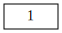

In [61]:
show(v_tree)

In [5]:
# start = time.time()
# k = 7
# states = []
# mutex_factors = []
# pre_factors = []
# eff_factors = []
# frame_factors = []
# for i in range(k):
#     # generate state
#     state_t = converter.generate_state(i)
#     states.append(state_t)
#     # generate mutex factor for the state
#     mutex_factor_t = converter.generate_mutex_factor(state_t)
#     mutex_factors.append(mutex_factor_t)
# for j in range(len(states)-1):
#     op_key = converter.generate_operator_key(j)
#     pre_factor, eff_factor, frame_factor = converter.generate_frame_op_factor(states[j], states[j+1], op_key)
#     pre_factors.append(pre_factor)
#     eff_factors.append(eff_factor)
#     frame_factors.append(frame_factor)
# initial_factor = converter.generate_initial_factor(states[0])
# goal_factor = converter.generate_goal_factor(states[-1])

# graph = gtsam.DiscreteFactorGraph()
# for m_factor in mutex_factors:
#     for f in m_factor:
#         graph.push_back(f)

# graph.push_back(goal_factor)
# graph.push_back(initial_factor)

# for op_factor in pre_factors:
#     graph.push_back(op_factor)

# for op_factor in eff_factors:
#     graph.push_back(op_factor)

# for frame_factor in frame_factors:
#     graph.push_back(frame_factor)

# val = graph.optimize()
# end = time.time()
# assert graph(val) == 1
# print("time taken:", end - start)

In [6]:
start = time.time()
k = 2
states = []
mutex_factors = []
pre_factors = []
eff_factors = []
frame_factors = []
for i in range(k):
    # generate state
    state_t = converter.generate_state(i)
    states.append(state_t)
    # generate mutex factor for the state
    mutex_factor_t = converter.generate_mutex_factor(state_t)
    mutex_factors.append(mutex_factor_t)

operators = []
for j in range(k-1):
    op_key = converter.generate_operator_key(j)
    operators.append(op_key)
    pre_factor, eff_factor, frame_factor = converter.generate_frame_op_factor(states[j], states[j+1], op_key)
    pre_factors.append(pre_factor)
    eff_factors.append(eff_factor)
    frame_factors.append(frame_factor)
initial_factor = converter.generate_initial_factor(states[0])
goal_factor = converter.generate_goal_factor(states[-1])

graph = gtsam.DiscreteFactorGraph()
for m_factor in mutex_factors:
    for f in m_factor:
        graph.push_back(f)

graph.push_back(goal_factor)
graph.push_back(initial_factor)

for op_factor in pre_factors:
    graph.push_back(op_factor)

for op_factor in eff_factors:
    graph.push_back(op_factor)

for frame_factor in frame_factors:
    graph.push_back(frame_factor)
# this is where the planning happens
# enum OrderingType { COLAMD, METIS, NATURAL, CUSTOM };
# orderingType  = gtsam.Ordering.OrderingType.METIS
# dag = graph.maxProduct(orderingType)


ordering = gtsam.Ordering()
# From Initial State
# for j in range(k):
#     for state in states[j]:
#         ordering.push_back(state[0])
#     if j < k-1:
#         ordering.push_back(operators[j][0])

# From Goal State
for j in reversed(range(k)):
    if j < k-1:
        ordering.push_back(operators[j][0])
    for state in states[j]:
        ordering.push_back(state[0])

# Mixed 1/3
# for i in range(k//3):
#     for state in states[i]:
#         ordering.push_back(state[0])
#     if i < k-1:
#         ordering.push_back(operators[i][0])
# for j in range(k-1, k//3-1, -1):
#     if j < k-1:
#         ordering.push_back(operators[j][0])
#     for state in states[j]:
#         ordering.push_back(state[0])

# Mixed 1/2
# for i in range(k//2):
#     for state in states[i]:
#         ordering.push_back(state[0])
#     if i < k-1:
#         ordering.push_back(operators[i][0])
# for j in range(k-1, k//2-1, -1):
#     if j < k-1:
#         ordering.push_back(operators[j][0])
#     for state in states[j]:
#         ordering.push_back(state[0])

# Mixed 2/3
# for i in range(2*k//3):
#     for state in states[i]:
#         ordering.push_back(state[0])
#     if i < k-1:
#         ordering.push_back(operators[i][0])
# for j in range(k-1, 2*k//3-1, -1):
#     if j < k-1:
#         ordering.push_back(operators[j][0])
#     for state in states[j]:
#         ordering.push_back(state[0])

# for j in reversed(range(k)):
#     if j < k-1:
#         ordering.push_back(operators[j][0])
    
# for j in reversed(range(k)):
#     for state in states[j]:
#         ordering.push_back(state[0])

minigraph = gtsam.DiscreteFactorGraph()

dag = graph.maxProduct(ordering)
result = dag.argmax()

# result = graph.optimize()

end = time.time()
assert graph(result) == 1
print("time taken:", end - start)

In [6]:
# graph, val, k = plan(12)

In [1]:
print(graph)

NameError: name 'graph' is not defined

In [8]:
result

DiscreteValues{0: 4, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 4, 7: 4, 8: 4, 9: 4, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1, 15: 0, 16: 4, 17: 4, 18: 4, 19: 1, 20: 0, 21: 0, 22: 0, 23: 0, 24: 1, 25: 4, 26: 4, 27: 4, 28: 1, 29: 0, 30: 1, 31: 0, 32: 1, 33: 1, 34: 0, 35: 4, 36: 4, 37: 1, 38: 1, 39: 0, 40: 0, 41: 0, 42: 1, 43: 2, 44: 4, 45: 4, 46: 1, 47: 1, 48: 0, 49: 1, 50: 1, 51: 1, 52: 2, 53: 0, 54: 4, 55: 1, 56: 1, 57: 1, 58: 0, 59: 0, 60: 1, 61: 2, 62: 3, 63: 1, 64: 11, 65: 2, 66: 15, 67: 3, 68: 19}

In [9]:
graph(result)

1.0

In [10]:
op_consts = []
for i in range(graph.size()-1, graph.size()-k, -1):
    op_consts.append(graph.at(i))
val_list = []
for op_const in reversed(op_consts):
    print(converter.ops_names[result[op_const.operatorKey()]])

pick-up b
stack b a
pick-up c
stack c b
pick-up d
stack d c
